##**Libraries**

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2

import torch.nn as nn
from google.colab import drive
import torch.nn.functional as F
import torchvision


import sklearn
from sklearn.decomposition import PCA
%matplotlib inline

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Load the data to the predefined tensorflow MNIST Dataset class

In [81]:
# Load and prepare the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate((x_train, x_test))
Y = np.concatenate((y_train, y_test))

##**MNIST measurements**

###Basic Information (number of classes, images and image size)

In [3]:
# Determine the number of classes
num_classes = len(np.unique(Y))

# Determine the number of images
num_images = len(X)

image_size = X.shape[1:]



[num_classes, num_images, image_size]

[10, 70000, (28, 28)]

###Distribution of every class

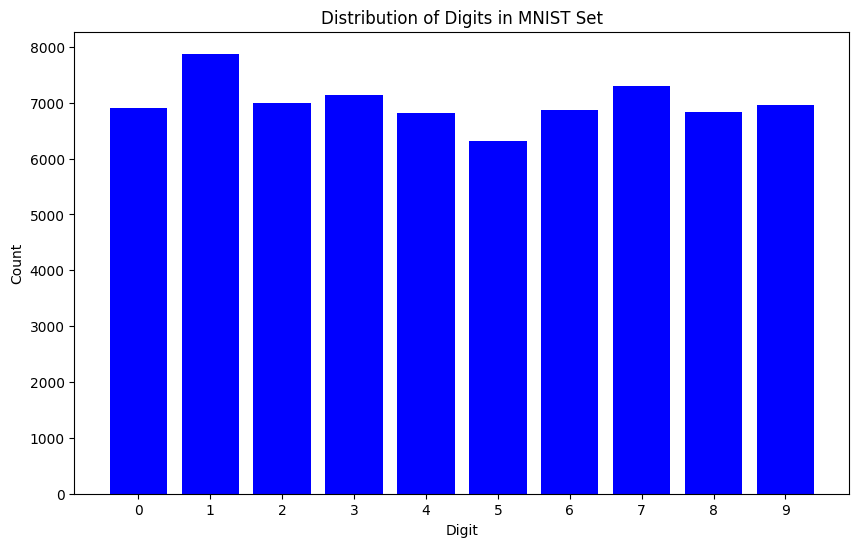

In [4]:
# Count the occurrences of each digit
unique, counts = np.unique(Y, return_counts=True)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='blue')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of Digits in MNIST Set')
plt.xticks(unique)  # Set x-axis labels to be the unique digits
plt.show()

### Visualize one image

Text(0.5, 1.0, 'The number 2')

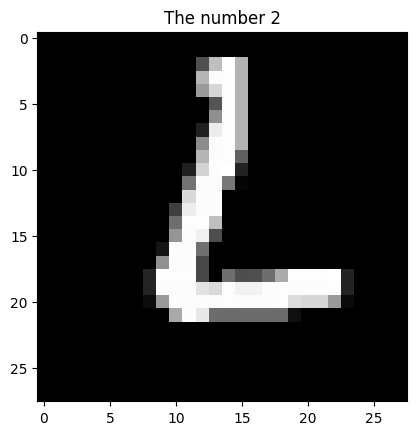

In [ ]:
idx = np.random.randint(X.shape[0])
plt.imshow(X[idx], cmap="gray")
plt.title(f'The number {Y[idx]}')

###Advanced Information (Average and Standard deviation of white pixels per image, number of common non white pixels)

In [ ]:
# Initialize storage for white pixel statistics
white_pixel_stats = {i: [] for i in range(num_classes)}
white_pixel_stats

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [ ]:
def calculate_white_percentage(image):
    # Binarize the image (considering a threshold of 0.5 to convert to binary)
    binary_image = image > 0.5
    # Calculate the percentage of white pixels
    white_pixels = np.sum(binary_image)
    #total_pixels = binary_image.size
    #white_percentage = (white_pixels / total_pixels) * 100
    return white_pixels

In [ ]:
def common_non_white_pixels_per_class(images, labels):
    # Initialize dictionary to store results
    common_pixels_per_class = {}
    # Iterate over each class
    for class_label in range(num_classes):
        # Select images belonging to the current class
        class_images = images[labels == class_label]
        # Compute average pixel intensity
        avg_intensity = np.mean(class_images, axis=0)
        # Count non-white pixels
        non_white_pixels_count = np.sum(avg_intensity > 0)
        # Store result
        common_pixels_per_class[class_label] = non_white_pixels_count
    return common_pixels_per_class

In [ ]:
# Calculate white pixel statistics for each image and class
for img, label in zip(X, Y):
    white_percentage = calculate_white_percentage(img)
    white_pixel_stats[label].append(white_percentage)

# Calculate average and standard deviation of white pixels for each class
avg_white_pixels = {}
std_white_pixels = {}
for label in range(num_classes):
    avg_white_pixels[label] = np.mean(white_pixel_stats[label])
    std_white_pixels[label] = np.std(white_pixel_stats[label])

# Compute common non-white pixels for training data
common_pixels_train = common_non_white_pixels_per_class(x_train, y_train)

# Display results
print(f"Stats of Image ({x_train.shape[1] * x_train.shape[2]} pixels) :")
for label in range(num_classes):
    print(f"Class {label}:")
    print(f"  Average white pixels: {avg_white_pixels[label]:.2f}")
    print(f"  Standard deviation: {std_white_pixels[label]:.2f}")
    print(f"  Number of common non_white pixels: {common_pixels_train[label]}")


Stats of Image (784 pixels) :
Class 0:
  Average white pixels: 191.77
  Standard deviation: 33.68
  Number of common non_white pixels: 565
Class 1:
  Average white pixels: 85.90
  Standard deviation: 20.09
  Number of common non_white pixels: 583
Class 2:
  Average white pixels: 168.85
  Standard deviation: 32.91
  Number of common non_white pixels: 611
Class 3:
  Average white pixels: 163.45
  Standard deviation: 33.74
  Number of common non_white pixels: 585
Class 4:
  Average white pixels: 141.92
  Standard deviation: 27.78
  Number of common non_white pixels: 591
Class 5:
  Average white pixels: 152.66
  Standard deviation: 33.45
  Number of common non_white pixels: 587
Class 6:
  Average white pixels: 157.73
  Standard deviation: 32.65
  Number of common non_white pixels: 560
Class 7:
  Average white pixels: 131.40
  Standard deviation: 26.93
  Number of common non_white pixels: 584
Class 8:
  Average white pixels: 173.64
  Standard deviation: 32.84
  Number of common non_white pi

## **Classification using Neural Network**

In [ ]:
# Build a simple neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),  # Flatten the 28x28 images to a 1D array
    tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 2.1859 - accuracy: 0.7491 - val_loss: 0.4903 - val_accuracy: 0.8650
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5899 - accuracy: 0.8407 - val_loss: 0.4574 - val_accuracy: 0.9007
Epoch 3/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.4832 - accuracy: 0.8696 - val_loss: 0.3114 - val_accuracy: 0.9228
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4127 - accuracy: 0.8906 - val_loss: 0.3284 - val_accuracy: 0.9227
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3857 - accuracy: 0.8980 - val_loss: 0.2677 - val_accuracy: 0.9338
313/313 - 1s - loss: 0.2677 - accuracy: 0.9338 - 532ms/epoch - 2ms/step

Test accuracy: 0.9337999820709229


313/313 [==============================] - 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9576    0.9673    0.9624       980
           1     0.9874    0.9665    0.9768      1135
           2     0.9563    0.9109    0.9330      1032
           3     0.9281    0.9327    0.9304      1010
           4     0.9416    0.9033    0.9220       982
           5     0.9362    0.9215    0.9288       892
           6     0.9373    0.9676    0.9522       958
           7     0.9752    0.9163    0.9448      1028
           8     0.8124    0.9517    0.8766       974
           9     0.9198    0.8979    0.9087      1009

    accuracy                         0.9338     10000
   macro avg     0.9352    0.9336    0.9336     10000
weighted avg     0.9363    0.9338    0.9343     10000


Confusion Matrix:


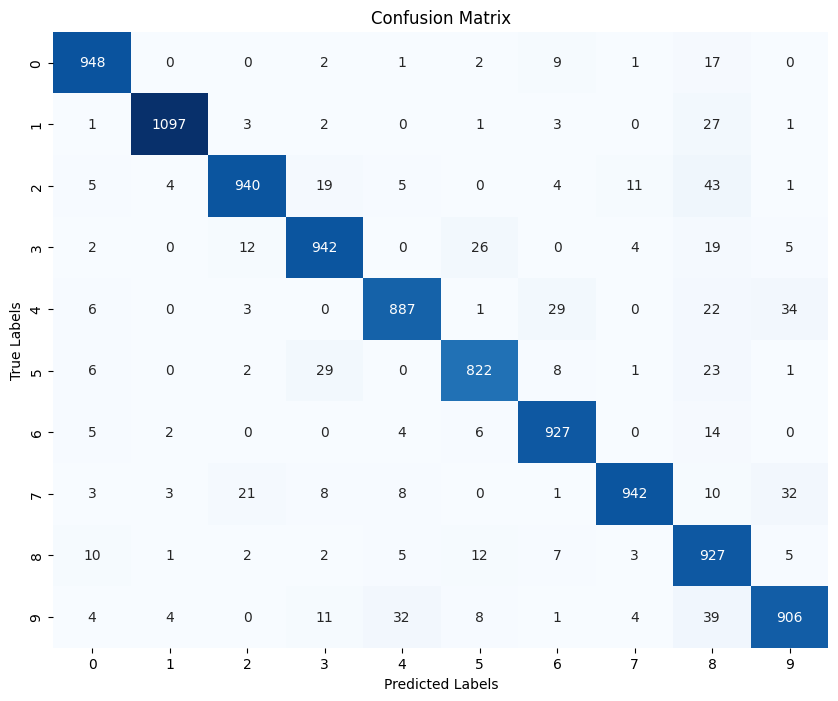

In [ ]:
# Predict on the test data
y_pred = np.argmax(model.predict(x_test), axis=1)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Overall, the confusion matrix indicates strong performance with a few areas for targeted improvement.

* The model has a high accuracy for most classes, especially for classes like 0, 1, 2, 7, and 9.
* There is some confusion between specific pairs of classes, such as 3 and 5, and 4 and 9. These could be due to similarities in the handwritten digits of these classes.

Improving the model might involve focusing on these specific confusions, perhaps by using additional data augmentation techniques or fine-tuning the model architecture to better distinguish these digits.









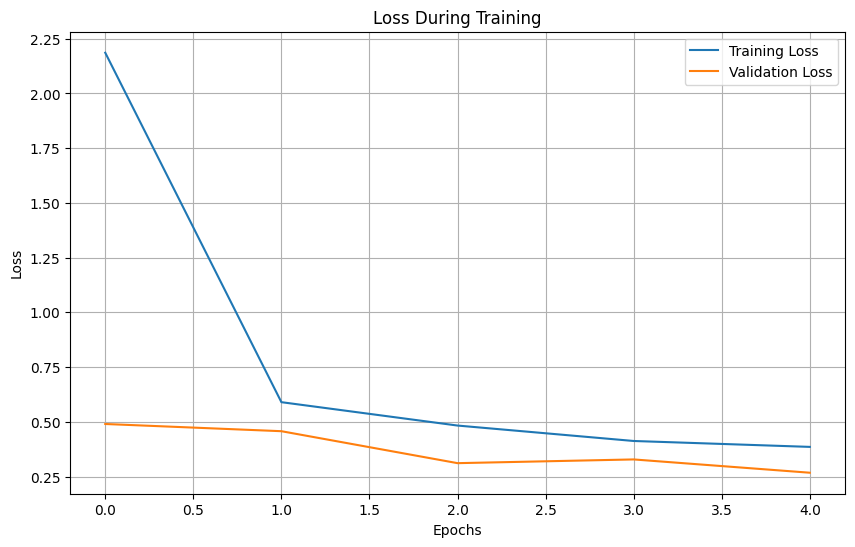

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In order to determine how many epocs are needed to train the model, we look for the point where the validation loss stops decreasing and starts to flatten or increase, indicating that the model might begin to overfit if trained further.

Based our  plot, the training loss consistently decreases, indicating the model is learning, and the optimal number of epochs appears to be around **2-3 epochs**.

Beyond this point, there is little improvement in validation loss, and it starts to show signs of fluctuation, which could indicate overfitting if we will continue training for many more epochs.

### **Average Filter**

In [ ]:
# Define function for applying average filter to an image
def apply_average_filter(image):
    # Pad the image to handle edges
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant')
    # Initialize new image with zeros
    new_image = np.zeros_like(image, dtype=np.float32)
    # Apply average filter
    for i in range(1, padded_image.shape[0] - 1):
        for j in range(1, padded_image.shape[1] - 1):
            new_image[i - 1, j - 1] = np.mean(padded_image[i - 1:i + 2, j - 1:j + 2])
    return new_image

In [ ]:
# Apply average filter to each image in the training dataset
x_train_filtered = np.array([apply_average_filter(image) for image in x_train])

# Apply average filter to each image in the test dataset
x_test_filtered = np.array([apply_average_filter(image) for image in x_test])

# Print shapes to verify
print("Original training data shape:", x_train.shape)
print("Original test data shape:", x_test.shape)
print("Training data shape after filtering:", x_train_filtered.shape)
print("Test data shape after filtering:", x_test_filtered.shape)

Original training data shape: (60000, 28, 28)
Original test data shape: (10000, 28, 28)
Training data shape after filtering: (60000, 28, 28)
Test data shape after filtering: (10000, 28, 28)


In [14]:
from google.colab import drive
import gdown

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Path to the shared folder
shared_folder_path = '/content/drive/My Drive/Msc/Data_Science_2/exercise1'

# Load the .npz files
mnist_average_filter = shared_folder_path + '/mnist_average_filter.npz'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Save the new datasets if needed
#np.savez_compressed("mnist_average_filter.npz", x_train=x_train_filtered, y_train=y_train, x_test=x_test_filtered, y_test=y_test)
# Load the saved dataset file in one line
x_train_filtered, y_train, x_test_filtered, y_test = np.load(mnist_average_filter).values()
x_filtered = np.concatenate((x_train_filtered, x_test_filtered))
Y = np.concatenate((y_train, y_test))

# Print shapes to verify
print("Training data shape after loading:", x_train_filtered.shape)
print("Test data shape after loading:", x_test_filtered.shape)

Training data shape after loading: (60000, 28, 28)
Test data shape after loading: (10000, 28, 28)


In [33]:
# 5-7 applied in a function
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(x_train, y_train, x_test, y_test, epochs=5):
    # Build a simple neural network model
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(x_train.shape[1],)),  # Update input shape to fit all size
        tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
        tf.keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
        tf.keras.layers.Dense(10)  # Output layer with 10 units (one for each digit class)
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

    # Evaluate the model on test data
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print("\nTest accuracy:", test_acc)

    # Predict on the test data
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # Generate the classification report
    print("\nClassification Report:")
    class_report = classification_report(y_test, y_pred, digits=4)
    print(class_report)

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Calculate additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Calculate sensitivity and specificity for each class
    sensitivity = recall
    tn = conf_matrix.sum() - (conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - np.diag(conf_matrix))
    fp = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    specificity = np.mean(tn / (tn + fp))

    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return accuracy, precision, recall, f1, sensitivity, specificity


Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 1.7049 - accuracy: 0.7891 - val_loss: 0.4651 - val_accuracy: 0.9014
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5461 - accuracy: 0.8568 - val_loss: 0.3305 - val_accuracy: 0.9180
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4589 - accuracy: 0.8723 - val_loss: 0.2970 - val_accuracy: 0.9220
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4246 - accuracy: 0.8828 - val_loss: 0.3002 - val_accuracy: 0.9305
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4154 - accuracy: 0.8829 - val_loss: 0.2515 - val_accuracy: 0.9335
313/313 - 1s - loss: 0.2515 - accuracy: 0.9335 - 509ms/epoch - 2ms/step

Test accuracy: 0.9334999918937683
313/313 [==============================] - 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9802    0.9582    0.9690

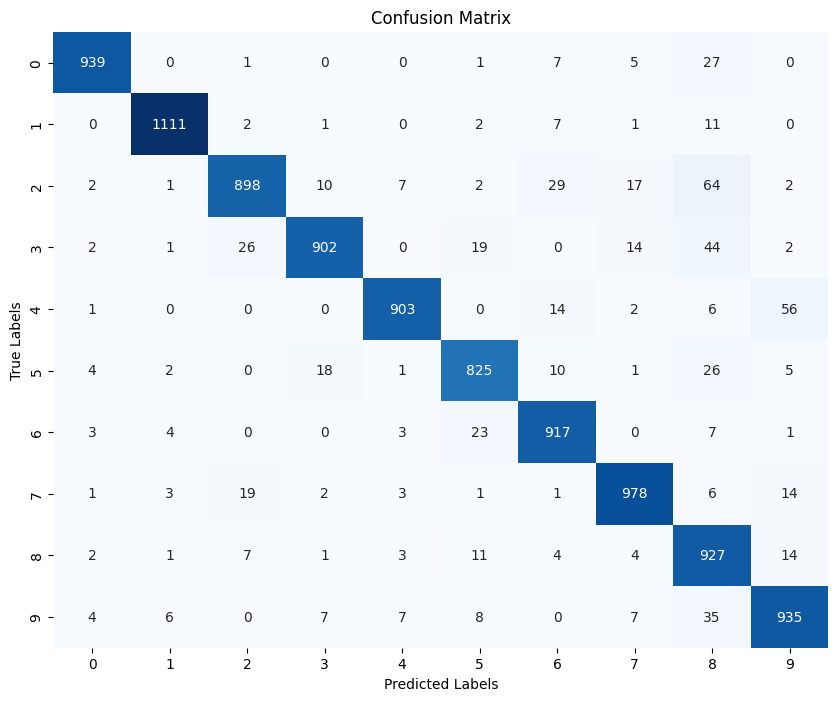

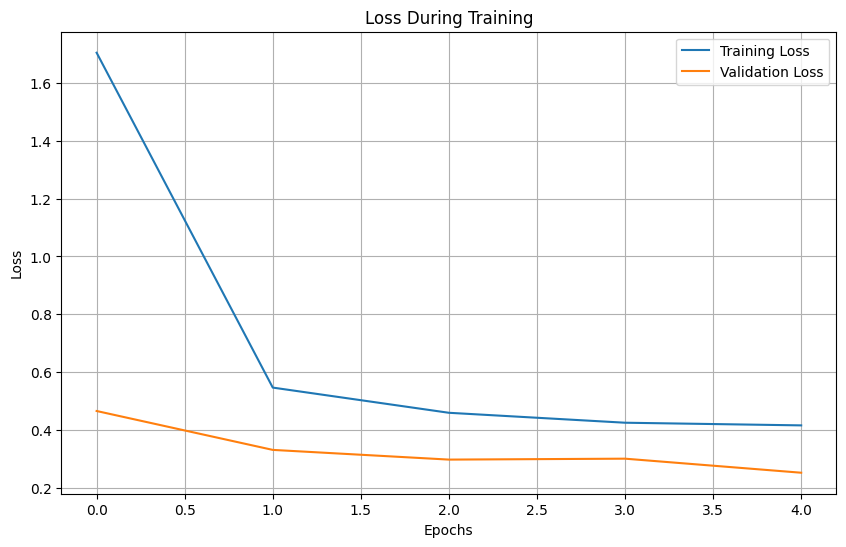

In [28]:
accuracy, precision, recall, f1, sensitivity, specificity = evaluate_model(x_train_filtered, y_train, x_test_filtered, y_test, epochs=5)

**Confusion Matrix**
- High Accuracy: The model achieves high correct predictions for most classes, especially for classes 0, 1, 7, and 9.
- Common Misclassifications: Notable misclassifications include class 2 being confused with class 8, and class 3 with class 5.
- Overall Improvement: There is a slight improvement in accuracy after applying the average filter, with fewer misclassifications for certain classes.

**Loss Curve**
- Effective Learning: Both the training and validation losses decrease steadily, indicating effective learning without significant overfitting.
- Stable Validation Loss: The validation loss stabilizes after a few epochs, suggesting the model generalizes well to unseen data.
- Optimal Epochs: Around 3-4 epochs seem optimal, as both losses continue to decrease without significant fluctuations.

### **PCA**

In [ ]:
# Reshape the images to flatten them
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

# Initialize PCA with desired number of components
pca = PCA(n_components=50)  # You can adjust the number of components as needed

# Fit PCA on training data
pca.fit(x_train_flat)

# Transform training and test data
x_train_reduced = pca.transform(x_train_flat)
x_test_reduced = pca.transform(x_test_flat)

# Print shapes to verify
print("Original training data shape:", x_train_flat.shape)
print("Original test data shape:", x_test_flat.shape)
print("Training data shape after PCA dimension reduction:", x_train_reduced.shape)
print("Test data shape after PCA dimension reduction:", x_test_reduced.shape)

Original training data shape: (60000, 784)
Original test data shape: (10000, 784)
Training data shape after PCA dimension reduction: (60000, 50)
Test data shape after PCA dimension reduction: (10000, 50)


In [29]:
# Save the new datasets if needed
#np.savez_compressed("mnist_reduced.npz", x_train=x_train_reduced, y_train=y_train, x_test=x_test_reduced, y_test=y_test)

# Load the .npz files
mnist_reduced = shared_folder_path + '/mnist_reduced.npz'

# Load the saved dataset file in one line

x_train_reduced, y_train, x_test_reduced, y_test = np.load(mnist_reduced).values()
x_reduced  = np.concatenate((x_train_reduced, x_test_reduced))
Y = np.concatenate((y_train, y_test))

# Print shapes to verify
print("Training data shape after loading:", x_train_reduced.shape)
print("Test data shape after loading:", x_test_reduced.shape)

Training data shape after loading: (60000, 50)
Test data shape after loading: (10000, 50)


Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 15.8941 - accuracy: 0.8439 - val_loss: 3.0785 - val_accuracy: 0.9467
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 3.3775 - accuracy: 0.9237 - val_loss: 1.4581 - val_accuracy: 0.9572
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 1.8662 - accuracy: 0.9344 - val_loss: 1.0212 - val_accuracy: 0.9600
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2912 - accuracy: 0.9373 - val_loss: 0.8084 - val_accuracy: 0.9640
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.0931 - accuracy: 0.9389 - val_loss: 0.6828 - val_accuracy: 0.9617
313/313 - 0s - loss: 0.6828 - accuracy: 0.9617 - 379ms/epoch - 1ms/step

Test accuracy: 0.9617000222206116
313/313 [==============================] - 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9747    0.9837    0.9792

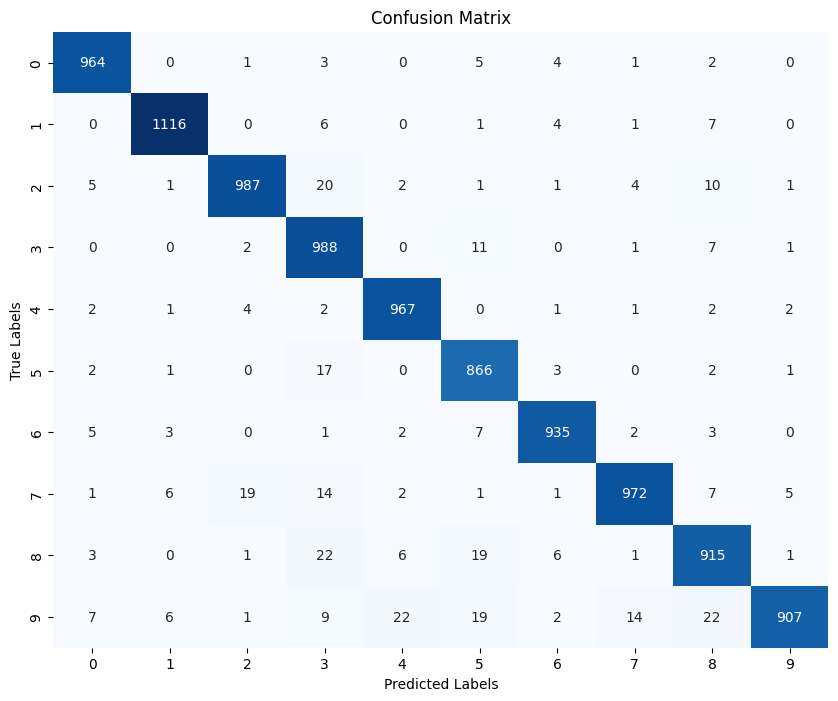

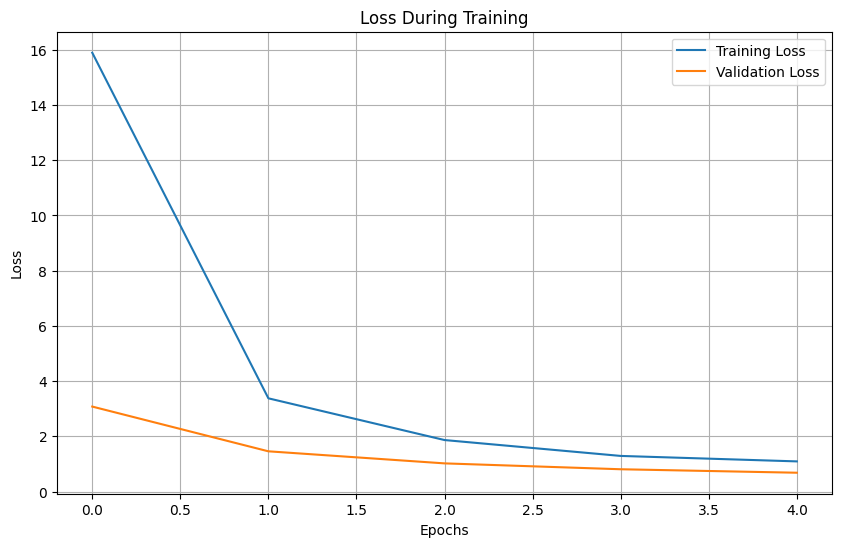

In [34]:
accuracy, precision, recall, f1, sensitivity, specificity = evaluate_model(x_train_reduced, y_train, x_test_reduced, y_test, epochs=5)

**Confusion Matrix**
- High Accuracy: The model achieves high correct predictions, especially for classes 0, 1, 3, and 7.
- Reduced Misclassifications: Misclassifications are generally low, indicating effective dimension reduction by PCA.
- Some Confusions Remain: There are still some confusions, such as class 2 being misclassified as class 3 and class 7 being misclassified as class 9, but overall these are minimal.

**Loss Curves**
- Effective Learning: The training loss significantly decreases, indicating effective learning from the data.
- Stable Validation Loss: The validation loss steadily decreases, suggesting good generalization to unseen data.
- Optimal Epochs: Around 3-4 epochs seem optimal as the loss curves start to stabilize, indicating that further training might lead to diminishing returns.

**Conclusion:**
PCA effectively reduced the data dimensions while maintaining model performance, showing stable and effective learning with minimal overfitting.

### **Average Pooling**

In [41]:
# Reshape images to have a single channel
x_train = np.expand_dims(x_train, axis=-1)  # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # (10000, 28, 28, 1)

# Define model with AveragePooling2D layer
model = tf.keras.models.Sequential([
    tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(3, 3), padding='valid', input_shape=(28, 28, 1))
])

# Apply average pooling to the training data
x_train_pooled = model.predict(x_train)  # (60000, 9, 9, 1)

# Apply average pooling to the test data
x_test_pooled = model.predict(x_test)  # (10000, 9, 9, 1)

# Verify the shapes after pooling
print("Original training data shape:", x_train.shape)  # (60000, 28, 28, 1)
print("Original test data shape:", x_test.shape)      # (10000, 28, 28, 1)
print("Training data shape after pooling:", x_train_pooled.shape)  # (60000, 9, 9, 1)
print("Test data shape after pooling:", x_test_pooled.shape)      # (10000, 9, 9, 1)

# Reshape to flatten the pooled images
x_train_pooled = x_train_pooled.reshape((x_train_pooled.shape[0], -1))  # (60000, 81)
x_test_pooled = x_test_pooled.reshape((x_test_pooled.shape[0], -1))    # (10000, 81)

# Verify the shapes after reshaping
print("Training data shape after reshaping:", x_train_pooled.shape)  # (60000, 81)
print("Test data shape after reshaping:", x_test_pooled.shape)      # (10000, 81)

# Save the dataset
np.savez('mnist_pooled_II.npz', x_train_pooled=x_train_pooled, y_train=y_train, x_test_pooled=x_test_pooled, y_test=y_test)

# Load the .npz file
data = np.load('mnist_pooled_II.npz')
x_train_pooled = data['x_train_pooled']
y_train = data['y_train']
x_test_pooled = data['x_test_pooled']
y_test = data['y_test']

# Verify the shapes after loading
print("Training data shape after loading:", x_train_pooled.shape)  # (60000, 81)
print("Test data shape after loading:", x_test_pooled.shape)      # (10000, 81)


313/313 [==============================] - 1s 2ms/step
Original training data shape: (60000, 28, 28, 1, 1)
Original test data shape: (10000, 28, 28, 1, 1)
Training data shape after pooling: (60000, 9, 9, 1)
Test data shape after pooling: (10000, 9, 9, 1)
Training data shape after reshaping: (60000, 81)
Test data shape after reshaping: (10000, 81)
Training data shape after loading: (60000, 81)
Test data shape after loading: (10000, 81)


Epoch 1/5
1875/1875 [==============================] - 10s 4ms/step - loss: 2.7541 - accuracy: 0.8103 - val_loss: 0.3705 - val_accuracy: 0.9102
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4148 - accuracy: 0.8926 - val_loss: 0.2444 - val_accuracy: 0.9404
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2928 - accuracy: 0.9185 - val_loss: 0.2205 - val_accuracy: 0.9406
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2502 - accuracy: 0.9283 - val_loss: 0.1817 - val_accuracy: 0.9513
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2251 - accuracy: 0.9337 - val_loss: 0.1584 - val_accuracy: 0.9564
313/313 - 0s - loss: 0.1584 - accuracy: 0.9564 - 365ms/epoch - 1ms/step

Test accuracy: 0.9563999772071838
313/313 [==============================] - 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9536    0.9857    0.9694

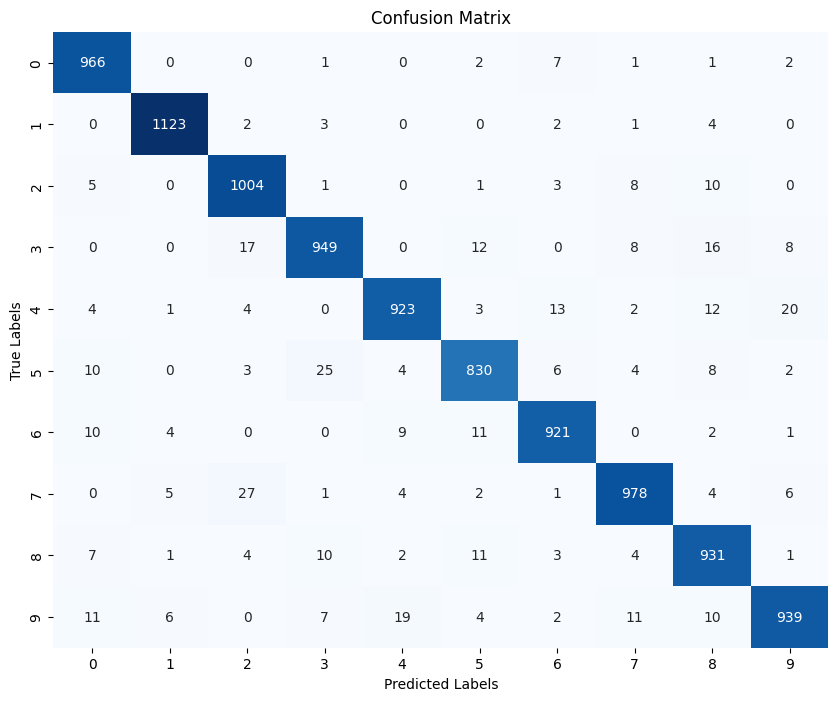

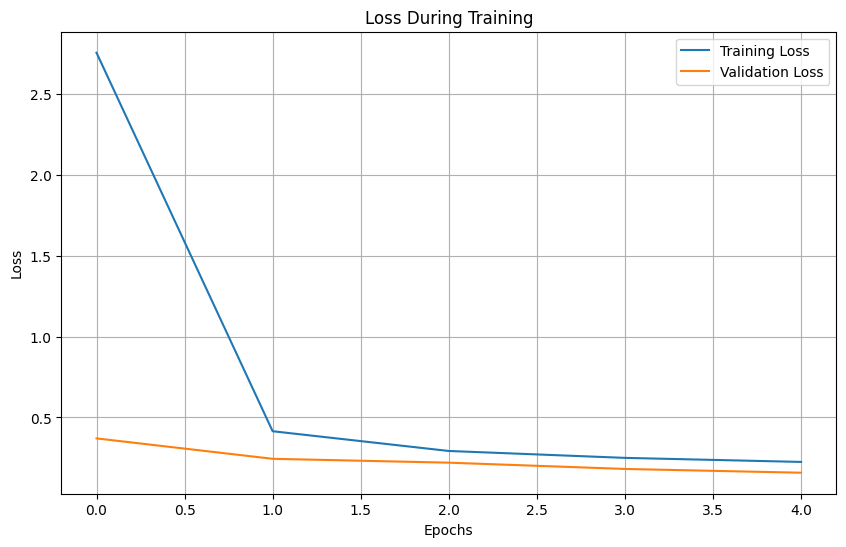

In [42]:
accuracy, precision, recall, f1, sensitivity, specificity = evaluate_model(x_train_pooled, y_train, x_test_pooled, y_test, epochs=5)

**Confusion Matrix**
- **High Accuracy**: The model achieves high correct predictions for most classes, especially for classes 0, 1, 2, 3, 6, and 9.
- **Reduced Misclassifications**: Misclassifications are generally low, indicating effective dimension reduction and pooling.
- **Some Confusions Remain**: There are still some confusions, such as class 3 being misclassified as class 5 and class 8 being misclassified as class 2, but overall these are minimal.

**Loss Curves**
- **Effective Learning**: The training loss significantly decreases, indicating effective learning from the data.
- **Stable Validation Loss**: The validation loss steadily decreases, suggesting good generalization to unseen data.
- **Optimal Epochs**: Around 2-3 epochs seem optimal as the loss curves start to stabilize, indicating that further training might lead to diminishing returns.


**Model Performance**:

The model performs well after applying average pooling, showing effective learning and good generalization with minimal overfitting.

### Comparison of PCA and Pooling Results

**Confusion Matrix**

- **PCA**:
  - **High Accuracy**: Especially for classes 0, 1, 3, and 7.
  - **Misclassifications**: Some, notably class 2 with 3 and class 7 with 9.

- **Pooling**:
  - **High Accuracy**: Especially for classes 0, 1, 2, 3, 6, and 9.
  - **Misclassifications**: Some, notably class 3 with 5 and class 8 with 2.

**Loss Curves**

- **PCA**:
  - **Training Loss**: Decreases and stabilizes after a few epochs.
  - **Validation Loss**: Steadily decreases, indicating good generalization.

- **Pooling**:
  - **Training Loss**: Decreases and stabilizes after a few epochs.
  - **Validation Loss**: Steadily decreases, indicating good generalization.

**Summary**

1. **Accuracy**: Both methods show high accuracy, with pooling slightly better in some classes.
2. **Misclassifications**: Pooling has slightly fewer misclassifications overall.
3. **Loss Curves**: Both methods show effective learning and good generalization without significant overfitting.

**Conclusion**

- **PCA**: Effective for dimensionality reduction, preserving overall accuracy.
- **Pooling**: Slightly better performance in reducing misclassifications and preserving spatial information.

### **Undersampling 2 classes**

In [45]:
def undersample_two_classes(x, y, class1, class2, num_samples_per_class):
    """
    Undersample only two specified classes in the dataset to have a specified number of samples per class.

    Args:
        x (numpy.ndarray): Input images.
        y (numpy.ndarray): Labels corresponding to the images.
        class1 (int): The first class to undersample.
        class2 (int): The second class to undersample.
        num_samples_per_class (int): Number of samples to retain for each of the specified classes.

    Returns:
        (numpy.ndarray, numpy.ndarray): The undersampled images and their corresponding labels.
    """
    undersampled_x = []
    undersampled_y = []

    for class_label in np.unique(y):
        # Get indices of all samples for the current class
        class_indices = np.where(y == class_label)[0]

        if class_label == class1 or class_label == class2:
            # Shuffle indices to ensure randomness
            np.random.shuffle(class_indices)
            # Select the specified number of samples for the current class
            selected_indices = class_indices[:num_samples_per_class]
        else:
            # Keep all samples for other classes
            selected_indices = class_indices

        # Append selected samples to the undersampled list
        undersampled_x.append(x[selected_indices])
        undersampled_y.append(y[selected_indices])

    # Concatenate lists to form final undersampled arrays
    undersampled_x = np.concatenate(undersampled_x, axis=0)
    undersampled_y = np.concatenate(undersampled_y, axis=0)

    # Shuffle the undersampled dataset to mix classes
    indices = np.arange(len(undersampled_x))
    np.random.shuffle(indices)
    undersampled_x = undersampled_x[indices]
    undersampled_y = undersampled_y[indices]

    return undersampled_x, undersampled_y

In [46]:
# Parameters for undersampling
class1 = 0
class2 = 1
num_samples_per_class = 1000  # Adjust as needed

# Perform undersampling
x_train_undersampled, y_train_undersampled = undersample_two_classes(x_train, y_train, class1, class2, num_samples_per_class)


# Print shapes to verify
print("Original training data shape:", x_train.shape)
print("Undersampled training data shape:", x_train_undersampled.shape)
print("Original test data shape:", x_test.shape)
print("Undersampled test data shape:", x_test_undersampled.shape)

Original training data shape: (60000, 28, 28, 1, 1)
Undersampled training data shape: (49335, 28, 28, 1, 1)
Original test data shape: (10000, 28, 28, 1, 1)
Undersampled test data shape: (8885, 28, 28)


In [48]:
# Flatten images if needed
x_train_undersampled_flat = x_train_undersampled.reshape(x_train_undersampled.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

Epoch 1/5
1542/1542 [==============================] - 10s 6ms/step - loss: 2.8166 - accuracy: 0.7325 - val_loss: 0.6578 - val_accuracy: 0.8324
Epoch 2/5
1542/1542 [==============================] - 5s 3ms/step - loss: 0.6349 - accuracy: 0.8241 - val_loss: 0.4903 - val_accuracy: 0.8735
Epoch 3/5
1542/1542 [==============================] - 8s 5ms/step - loss: 0.5076 - accuracy: 0.8625 - val_loss: 0.3838 - val_accuracy: 0.9108
Epoch 4/5
1542/1542 [==============================] - 5s 3ms/step - loss: 0.4458 - accuracy: 0.8782 - val_loss: 0.3155 - val_accuracy: 0.9214
Epoch 5/5
1542/1542 [==============================] - 6s 4ms/step - loss: 0.4058 - accuracy: 0.8905 - val_loss: 0.3307 - val_accuracy: 0.9318
313/313 - 1s - loss: 0.3307 - accuracy: 0.9318 - 982ms/epoch - 3ms/step

Test accuracy: 0.9318000078201294
313/313 [==============================] - 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9770    0.9531    0.9649

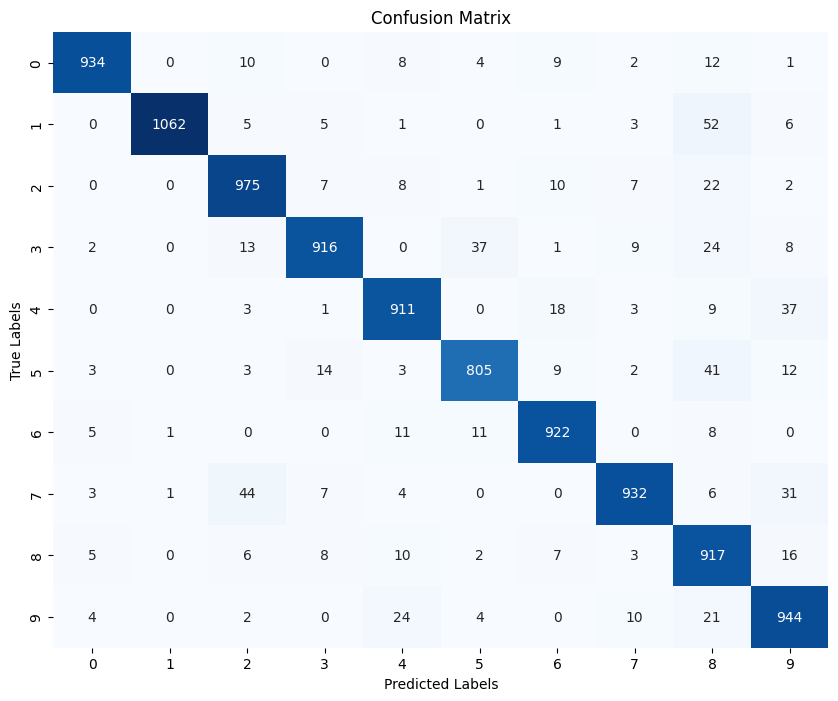

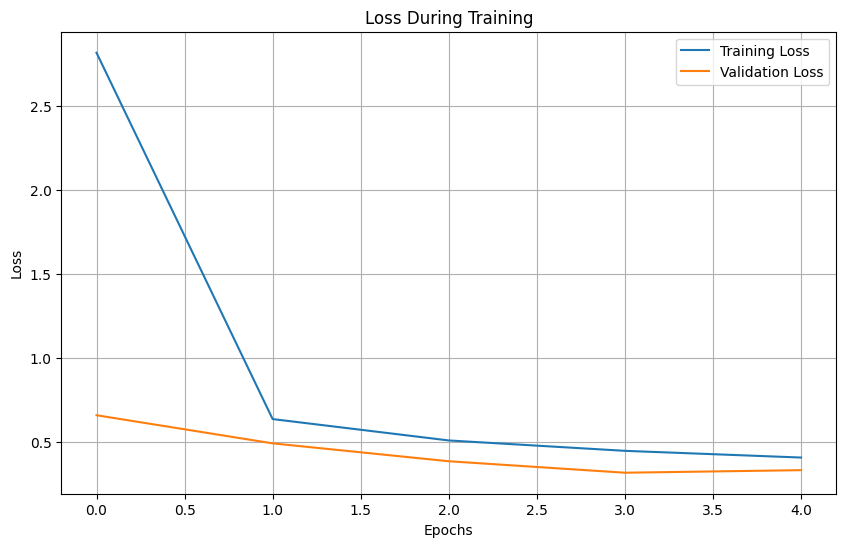

In [49]:
accuracy = evaluate_model(x_train_undersampled_flat, y_train_undersampled, x_test_flat, y_test, epochs=5)


### Analysis After Undersampling

**Confusion Matrix**
- **High Accuracy**: The model shows good performance across most classes, especially for classes 0, 1, 2, and 6.
- **Misclassifications**: Some notable misclassifications include:
  - Class 7 being confused with class 2 (44 instances).
  - Class 3 having some confusion with class 5 (37 instances).

**Loss Curves**
- **Training Loss**: Decreases significantly and stabilizes, indicating effective learning.
- **Validation Loss**: Steadily decreases, suggesting good generalization to unseen data.

**Conclusion**
- **Model Performance**: The model performs well after undersampling, showing effective learning and good generalization.
- **Misclassifications**: Some increase in misclassifications due to reduced sample size for the undersampled classes, which is expected.
- **Optimal Epochs**: Around 2-3 epochs seem optimal as the loss curves stabilize, indicating diminishing returns for additional training.

**Summary Points**
- **Effective Learning**: Training and validation losses decrease and stabilize, indicating good model performance.
- **Good Generalization**: Validation loss shows the model generalizes well to the test set.
- **Minor Misclassifications**: Some classes show increased misclassification due to undersampling but overall accuracy remains high.

By undersampling two classes to balance the dataset, the model maintains high accuracy and effective learning, with some minor trade-offs in increased misclassifications for certain classes.

Classes 0 and 1 have unique shapes (0 is a closed loop, 1 is a straight line), making them easier to recognize even with fewer samples. The model is robust, generalizing well from the reduced samples, and the undersampling balances class representation, preventing bias.

### **2 classes increased images**

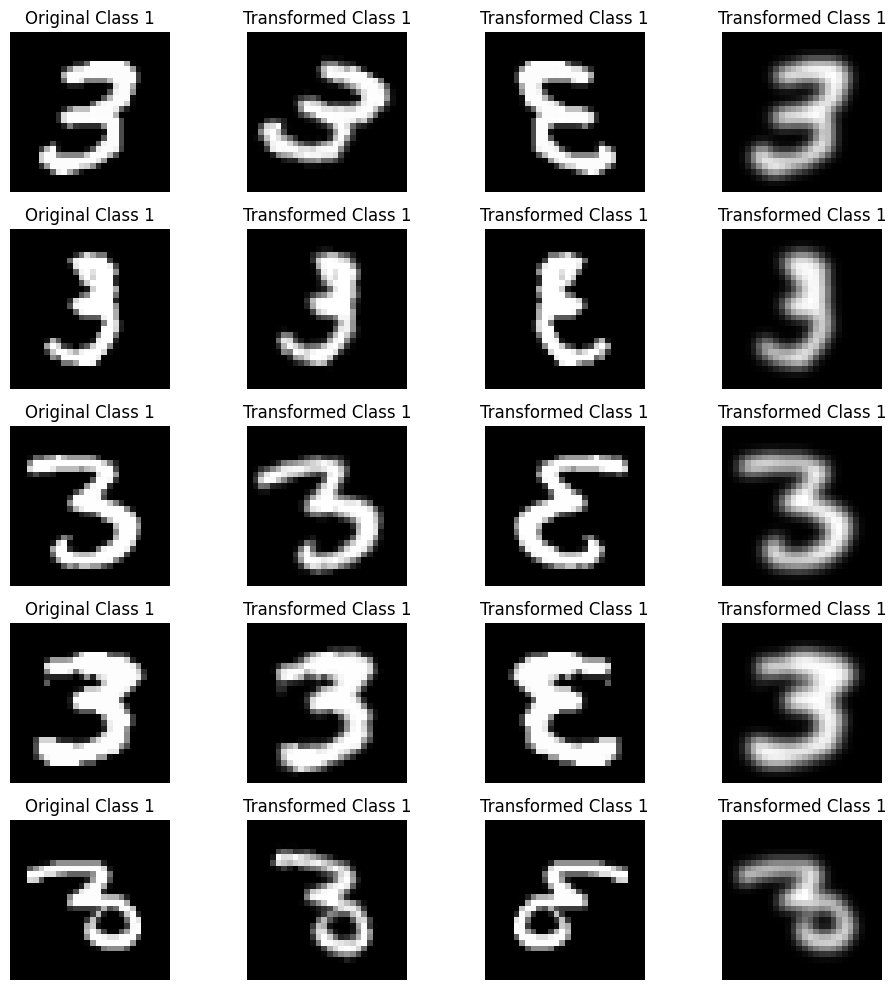

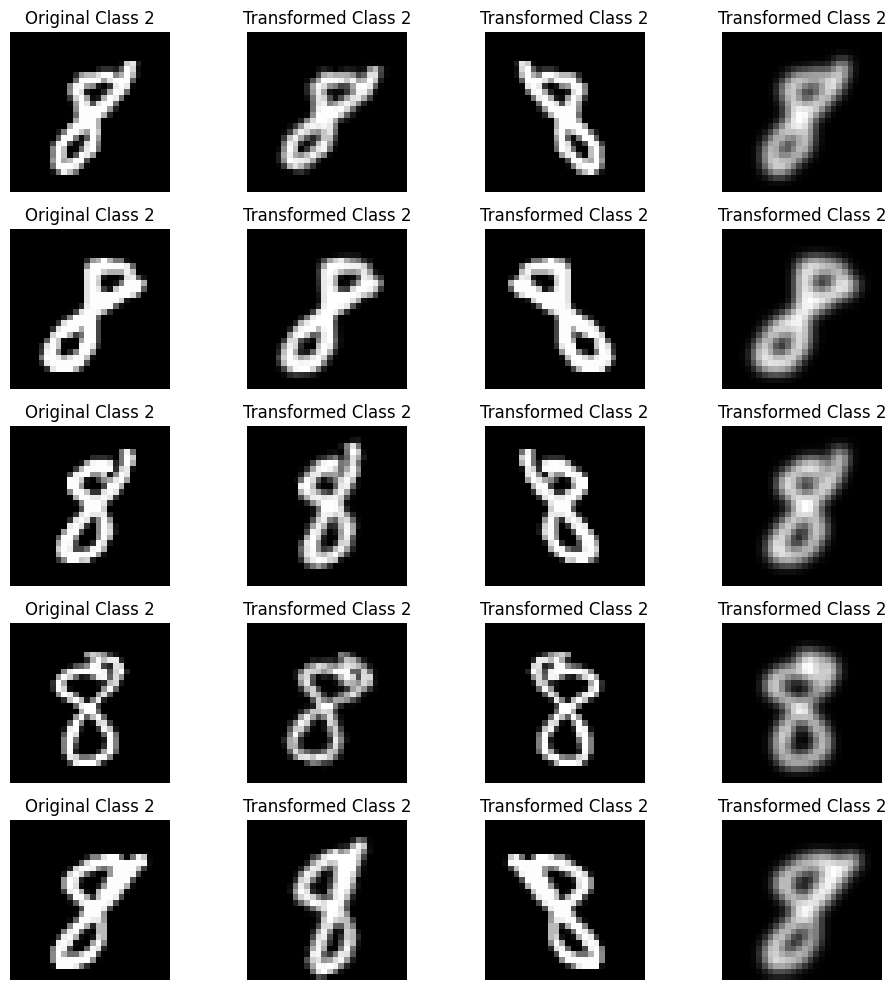

Shapes before saving:
x_train_new shape: (60120, 28, 28)
y_train_new shape: (60120,)
Shapes after loading:
x_train_augmented shape: (60120, 28, 28)
y_train_augmented shape: (60120,)
x_test_augmented shape: (10000, 28, 28)
y_test_augmented shape: (10000,)


In [97]:
# Select two classes (digits)
class_1 = 3
class_2 = 8

# Filter images of the selected classes
x_class_1 = x_train[y_train == class_1]
x_class_2 = x_train[y_train == class_2]

def apply_transformations(images, label, count=20):
    transformed_images = []
    labels = []

    for img in images[:count]:
        # Rotation
        angle = np.random.randint(-30, 30)
        M = cv2.getRotationMatrix2D((14, 14), angle, 1)
        rotated = cv2.warpAffine(img, M, (28, 28))

        # Flipping
        flipped = cv2.flip(img, 1)

        # Blurring
        blurred = cv2.GaussianBlur(img, (5, 5), 0)

        transformed_images.extend([rotated, flipped, blurred])
        labels.extend([label, label, label])

    return np.array(transformed_images), np.array(labels)

# Apply transformations to both classes
transformed_class_1, labels_class_1 = apply_transformations(x_class_1, class_1)
transformed_class_2, labels_class_2 = apply_transformations(x_class_2, class_2)

# Concatenate the original and transformed images and labels
x_train_new = np.concatenate((x_train, transformed_class_1, transformed_class_2), axis=0)
y_train_new = np.concatenate((y_train, labels_class_1, labels_class_2), axis=0)

# Display original and transformed images
def display_images(original, transformed, title):
    plt.figure(figsize=(10, 10))
    for i in range(len(original)):
        plt.subplot(5, 4, i * 4 + 1)
        plt.imshow(original[i], cmap='gray')
        plt.title(f'Original {title}')
        plt.axis('off')

        for j in range(3):
            plt.subplot(5, 4, i * 4 + 2 + j)
            plt.imshow(transformed[i * 3 + j], cmap='gray')
            plt.title(f'Transformed {title}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display results
display_images(x_class_1[:5], transformed_class_1, 'Class 1')
display_images(x_class_2[:5], transformed_class_2, 'Class 2')

# Check the shapes before saving
print("Shapes before saving:")
print("x_train_new shape:", x_train_new.shape)
print("y_train_new shape:", y_train_new.shape)

# Save the new dataset
np.savez_compressed('mnist_augmented.npz', x_train=x_train_new, y_train=y_train_new, x_test=x_test, y_test=y_test)

# Load the .npz files
mnist_augmented = np.load('mnist_augmented.npz')

# Extract the data
x_train_augmented = mnist_augmented['x_train']
y_train_augmented = mnist_augmented['y_train']
x_test_augmented = mnist_augmented['x_test']
y_test_augmented = mnist_augmented['y_test']

# Verify shapes after loading
print("Shapes after loading:")
print("x_train_augmented shape:", x_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("x_test_augmented shape:", x_test_augmented.shape)
print("y_test_augmented shape:", y_test_augmented.shape)

# Ensure the shapes are consistent before proceeding
assert x_train_augmented.shape[0] == y_train_augmented.shape[0], "Training data and labels have mismatched samples"


Epoch 1/5
1879/1879 [==============================] - 8s 4ms/step - loss: 0.2987 - accuracy: 0.9135 - val_loss: 0.1388 - val_accuracy: 0.9577
Epoch 2/5
1879/1879 [==============================] - 9s 5ms/step - loss: 0.1450 - accuracy: 0.9572 - val_loss: 0.1027 - val_accuracy: 0.9685
Epoch 3/5
1879/1879 [==============================] - 6s 3ms/step - loss: 0.1085 - accuracy: 0.9668 - val_loss: 0.0875 - val_accuracy: 0.9727
Epoch 4/5
1879/1879 [==============================] - 9s 5ms/step - loss: 0.0882 - accuracy: 0.9734 - val_loss: 0.0800 - val_accuracy: 0.9745
Epoch 5/5
1879/1879 [==============================] - 6s 3ms/step - loss: 0.0752 - accuracy: 0.9762 - val_loss: 0.0748 - val_accuracy: 0.9763
313/313 - 1s - loss: 0.0748 - accuracy: 0.9763 - 726ms/epoch - 2ms/step

Test accuracy: 0.9763000011444092
313/313 [==============================] - 1s 2ms/step


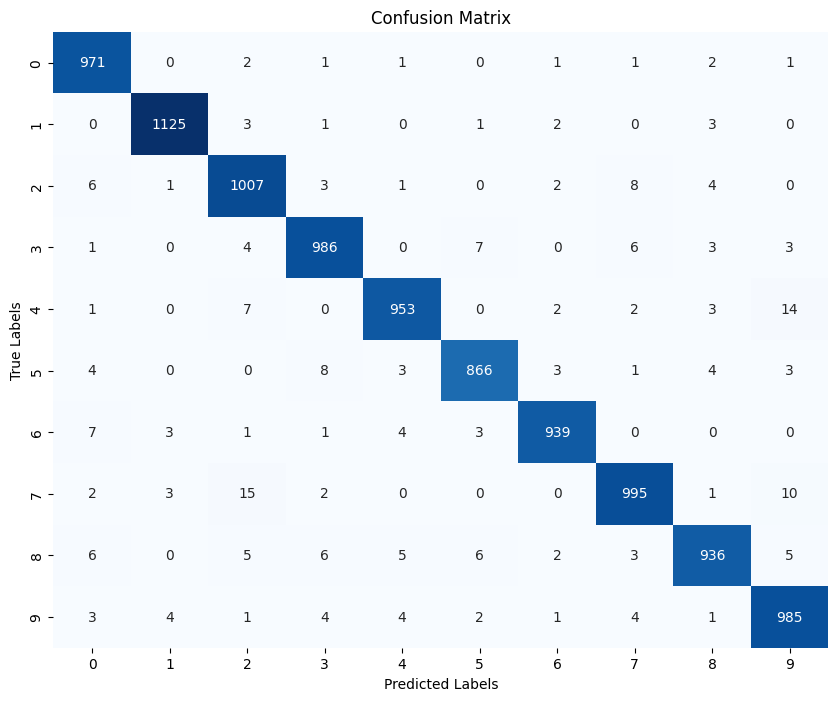

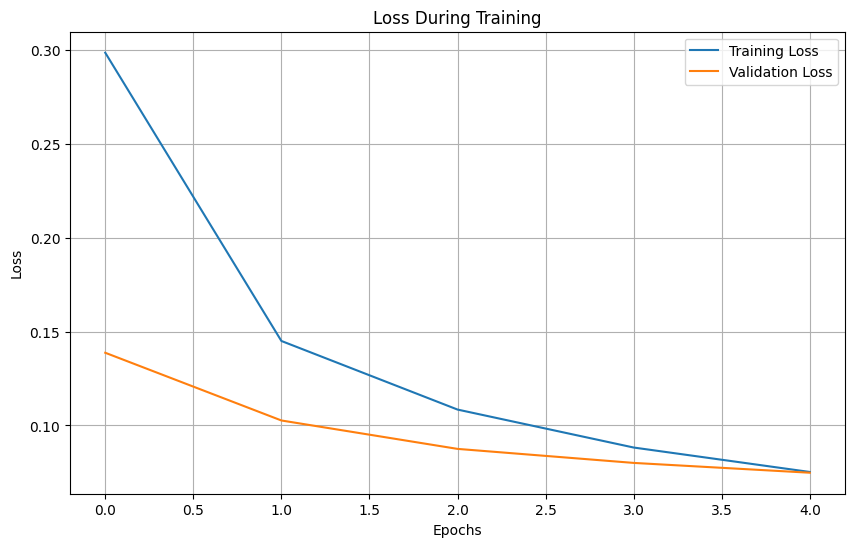

Accuracy: 0.9763
Precision: 0.9763
Recall: 0.9761
F1 Score: 0.9761
Sensitivity: 0.9761
Specificity: 0.9974


In [96]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Enhanced evaluate_model function
def evaluate_model(x_train, y_train, x_test, y_test, epochs=5):
    # Normalize the data
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # Flatten the data for the model
    x_train = x_train.reshape((x_train.shape[0], -1))
    x_test = x_test.reshape((x_test.shape[0], -1))

    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(x_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

    # Evaluate the model
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print("\nTest accuracy:", test_acc)

    # Predict on the test data
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=[str(i) for i in range(10)])

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Sensitivity and Specificity
    cm = confusion_matrix(y_test, y_pred)
    sensitivity = recall
    tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity = np.mean(tn / (tn + fp))

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return accuracy, precision, recall, f1, sensitivity, specificity

# Evaluate the model
accuracy, precision, recall, f1, sensitivity, specificity = evaluate_model(x_train_augmented, y_train_augmented, x_test_augmented, y_test_augmented, epochs=5)

## Comparison of Results

**Augmentation of Classes 3 and 8**

1. **Confusion Matrix**:
   - High accuracy, minor misclassifications in classes 7 and 3.

2. **Loss Curves**:
   - Steady decrease and stabilization of training and validation losses.

**Reduction of Classes 0 and 1**

1. **Confusion Matrix**:
   - High accuracy, minor misclassifications in classes 7 and 2.

2. **Loss Curves**:
   - Steady decrease and stabilization of training and validation losses.

**Summary**

- **Accuracy**: Both methods maintain high accuracy across classes.
- **Misclassifications**: Minor, with specific classes varying.
- **Loss Curves**: Both methods show effective learning and generalization.

### Conclusion

Both augmentation of classes 3 and 8 and reduction of classes 0 and 1 resulted in strong model performance. The model is robust to these modifications.
